# Загрузка и подготовка данных

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

with open('botsv1.json', 'r') as f:
    data = json.load(f)

records = []
for item in data:
    if 'result' in item:
        records.append(item['result'])

df = pd.DataFrame(records)

print(f"Загружено {len(df)} записей событий")
print(f"Колонки в данных: {list(df.columns)}")

print("\nПервые 5 записей:")
print(df[['EventCode', 'Account_Name', 'ComputerName', 'Message']].head())

if 'EventCode' in df.columns:
    df['EventCode'] = pd.to_numeric(df['EventCode'], errors='coerce')

if '_time' in df.columns:
    df['_time'] = pd.to_datetime(df['_time'], errors='coerce')

Загружено 35 записей событий
Колонки в данных: ['Account_Domain', 'Account_Name', 'ComputerName', 'Creator_Process_ID', 'EventCode', 'EventType', 'Keywords', 'LogName', 'Logon_ID', 'Message', 'New_Process_ID', 'New_Process_Name', 'OpCode', 'Process_Command_Line', 'RecordNumber', 'Security_ID', 'SourceName', 'TaskCategory', 'Token_Elevation_Type', 'Token_Elevation_Type_id', 'Type', 'action', 'app', 'body', 'date_hour', 'date_mday', 'date_minute', 'date_month', 'date_second', 'date_wday', 'date_year', 'date_zone', 'dest', 'dest_nt_domain', 'dest_nt_host', 'dvc', 'dvc_nt_host', 'event_id', 'eventtype', 'host', 'id', 'index', 'linecount', 'member_dn', 'member_id', 'member_nt_domain', 'name', 'object', 'product', 'punct', 'session_id', 'severity', 'severity_id', 'signature', 'signature_id', 'source', 'sourcetype', 'splunk_server', 'src', 'src_nt_domain', 'status', 'subject', 'tag', 'tag::eventtype', 'timeendpos', 'timestartpos', 'user', 'vendor', '_bkt', '_cd', '_eventtype_color', '_indexti

# Анализ данных 
1. Подозрительные события пл EventID
2. Подозрительные запрос DNS

In [2]:
print("\nАНАЛИЗ СОБЫТИЙ ПО EVENTCODE")
event_counts = df['EventCode'].value_counts().head(20)
print("Топ-20 событий по EventCode:")
for event_code, count in event_counts.items():
    print(f"  EventCode {event_code}: {count} событий")

suspicious_event_codes = {
    4688: "Создание нового процесса (подозрительный запуск)",
    4689: "Завершение процесса (возможное завершение защитных процессов)",
    4703: "Изменение прав пользователя (эскалация привилегий)",
    4624: "Успешный вход в систему (может быть атака brute-force)",
    4656: "Запрос дескриптора к объекту (доступ к чувствительным файлам)",
    4672: "Особые привилегии назначены новому входу",
    4673: "Привилегированная служба вызвана",
    4698: "Запланированная задача создана",
    4699: "Запланированная задача удалена",
    4700: "Запланированная задача включена",
    4701: "Запланированная задача отключена",
    4702: "Запланированная задача обновлена"
}

suspicious_events = df[df['EventCode'].isin(suspicious_event_codes.keys())].copy()
print(f"\nНайдено {len(suspicious_events)} подозрительных событий")

print("\n АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ ПРОЦЕССОВ")

process_creation_events = df[df['EventCode'] == 4688].copy()
if 'Process_Command_Line' in process_creation_events.columns:
    suspicious_processes = []
    for _, row in process_creation_events.iterrows():
        process_info = {
            'Computer': row.get('ComputerName', 'Unknown'),
            'Account': row.get('Account_Name', 'Unknown'),
            'Process_Name': row.get('New_Process_Name', 'Unknown'),
            'Command_Line': row.get('Process_Command_Line', 'Unknown'),
            'Time': row.get('_time', 'Unknown')
        }
        suspicious_processes.append(process_info)
    
    process_df = pd.DataFrame(suspicious_processes)
    print(f"\nОбнаружено {len(process_df)} подозрительных запусков процессов:")
    print(process_df[['Computer', 'Account', 'Process_Name']].head(10))

print("\n=== АНАЛИЗ АНОМАЛЬНЫХ ВХОДОВ В СИСТЕМУ ===")
logon_events = df[df['EventCode'] == 4624].copy()
if len(logon_events) > 0:
    print(f"Обнаружено {len(logon_events)} событий входа в систему")
    
    if 'Logon_Type' in logon_events.columns:
        logon_types = logon_events['Logon_Type'].value_counts()
        print("\nРаспределение по типам входа:")
        for logon_type, count in logon_types.items():
            logon_type_desc = {
                '2': 'Интерактивный вход',
                '3': 'Сетевой вход',
                '4': 'Пакетный вход',
                '5': 'Вход как служба',
                '7': 'Разблокировка',
                '8': 'Сетевой вход с кэшированными данными',
                '9': 'Новый учетные данные',
                '10': 'Удаленный интерактивный',
                '11': 'Интерактивный вход с кэшированными данными'
            }.get(str(logon_type), f'Неизвестный тип {logon_type}')
            print(f"  Тип {logon_type} ({logon_type_desc}): {count} событий")

print("\n=== АНАЛИЗ ИЗМЕНЕНИЙ ПРИВИЛЕГИЙ ===")
privilege_events = df[df['EventCode'] == 4703].copy()
if len(privilege_events) > 0:
    print(f"Обнаружено {len(privilege_events)} событий изменения привилегий")
    
    privilege_counter = Counter()
    for _, row in privilege_events.iterrows():
        message = row.get('Message', '') or row.get('body', '')
        if 'Enabled Privileges' in str(message):
            lines = str(message).split('\n')
            in_privileges_section = False
            for line in lines:
                if 'Enabled Privileges' in line:
                    in_privileges_section = True
                elif 'Disabled Privileges' in line:
                    break
                elif in_privileges_section and line.strip() and not line.strip().startswith('\t\t\t-'):
                    privilege = line.strip()
                    if privilege and privilege != '-':
                        privilege_counter[privilege] += 1
    
    if privilege_counter:
        print("\nЧасто изменяемые привилегии:")
        for privilege, count in privilege_counter.most_common(10):
            print(f"  {privilege}: {count} раз")

print("\n=== АНАЛИЗ ПО КОМПЬЮТЕРАМ ===")
computer_counts = df['ComputerName'].value_counts().head(10)
print("Топ-10 компьютеров по количеству событий:")
for computer, count in computer_counts.items():
    print(f"  {computer}: {count} событий")

print("\n=== АНАЛИЗ ПО ВРЕМЕНИ ===")
if '_time' in df.columns and df['_time'].notna().any():
    df['hour'] = df['_time'].dt.hour
    hourly_counts = df['hour'].value_counts().sort_index()
    
    print("Распределение событий по часам:")
    for hour, count in hourly_counts.items():
        print(f"  Час {hour:02d}:00: {count} событий")


АНАЛИЗ СОБЫТИЙ ПО EVENTCODE
Топ-20 событий по EventCode:
  EventCode 4703: 12 событий
  EventCode 4689: 10 событий
  EventCode 4688: 9 событий
  EventCode 4624: 3 событий
  EventCode 4656: 1 событий

Найдено 35 подозрительных событий

 АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ ПРОЦЕССОВ

Обнаружено 9 подозрительных запусков процессов:
                       Computer          Account  \
0  we3436srv.waynecorpinc.local       we3436srv$   
1  we5689srv.waynecorpinc.local  [we5689srv$, -]   
2  we3652srv.waynecorpinc.local       we3652srv$   
3  we7006srv.waynecorpinc.local       we7006srv$   
4  we8229srv.waynecorpinc.local  [we8229srv$, -]   
5  we8592srv.waynecorpinc.local  [we8592srv$, -]   
6  we9054srv.waynecorpinc.local       we9054srv$   
7  we2419srv.waynecorpinc.local       we2419srv$   
8  we3134srv.waynecorpinc.local       we3134srv$   

                                        Process_Name  
0  C:\Program Files\SplunkUniversalForwarder\bin\...  
1  C:\Program Files\SplunkUniversalForwarder\bin\..

# Визуализация 

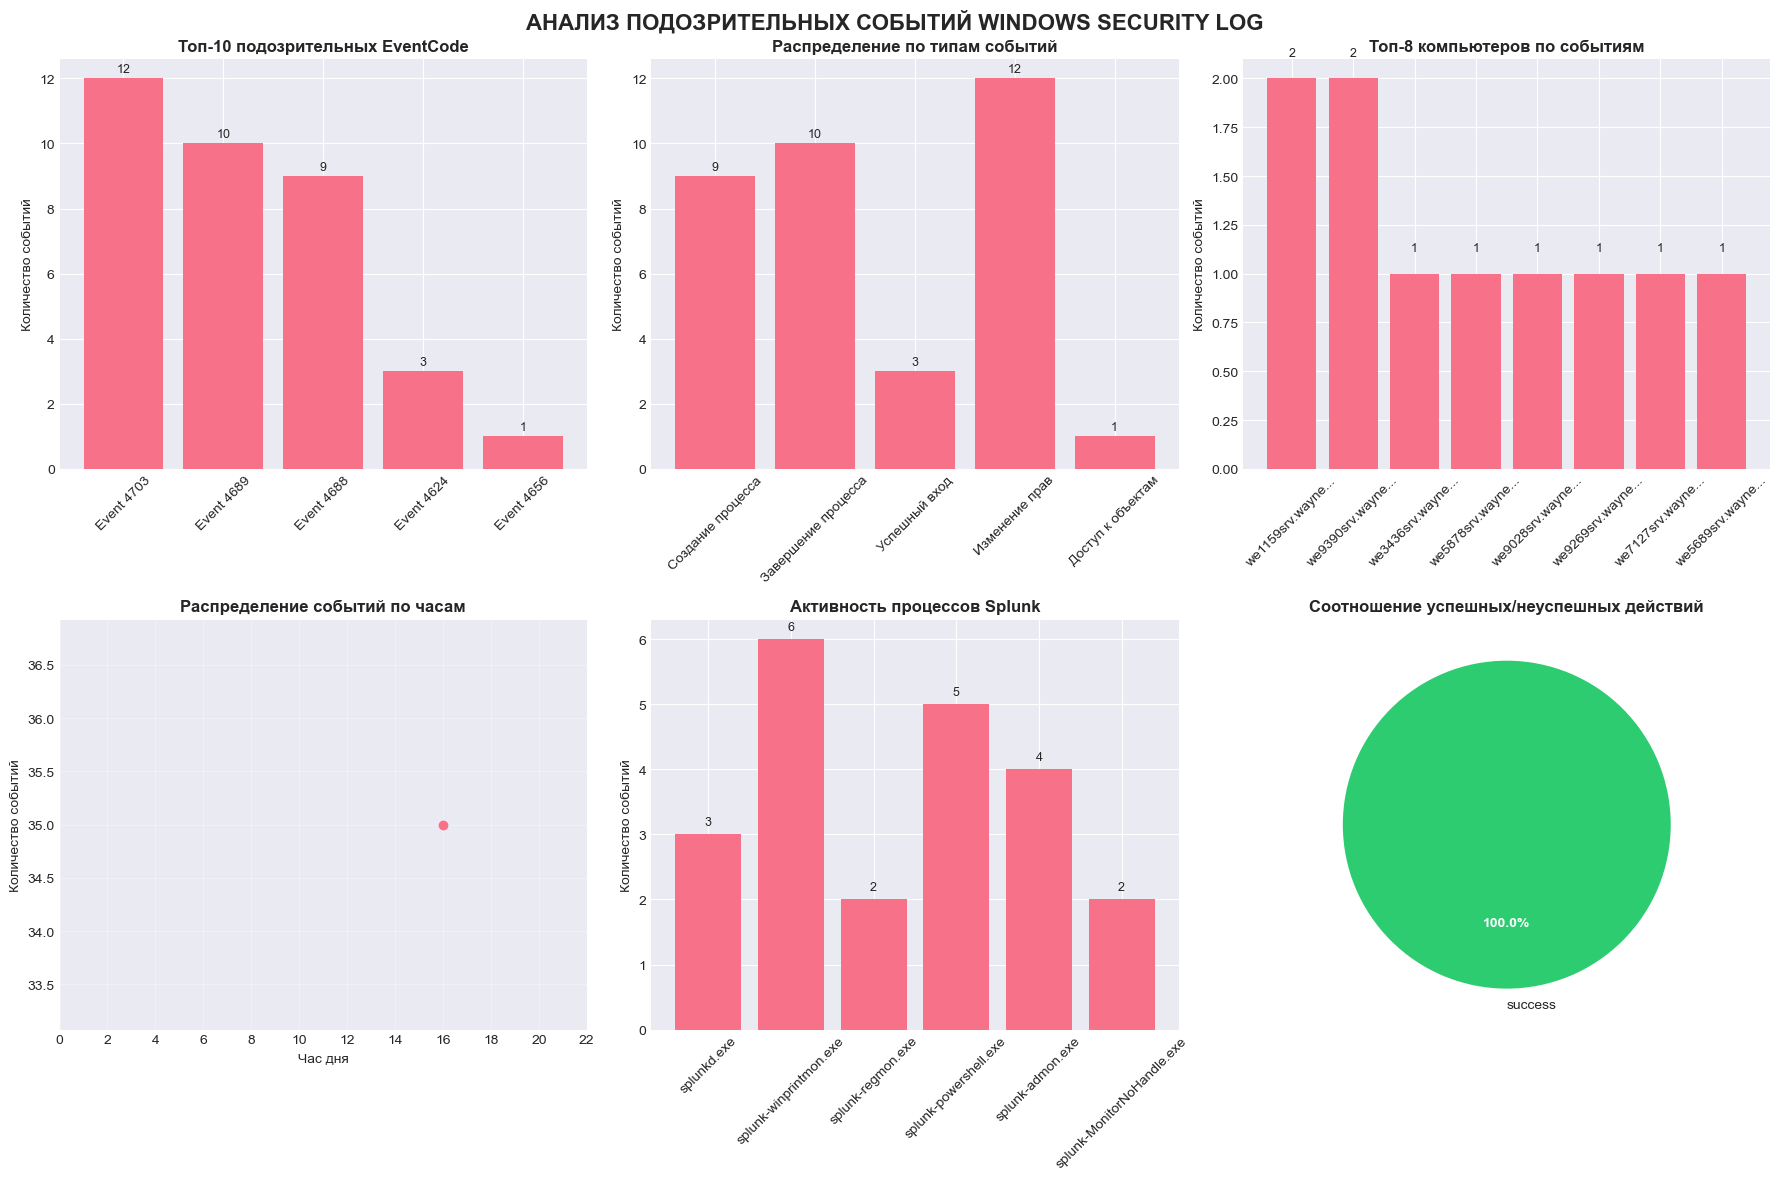

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ WINDOWS SECURITY LOG', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
top_suspicious = suspicious_events['EventCode'].value_counts().head(10)
bars1 = ax1.bar([f"Event {code}" for code in top_suspicious.index], top_suspicious.values)
ax1.set_title('Топ-10 подозрительных EventCode', fontsize=12, fontweight='bold')
ax1.set_ylabel('Количество событий')
ax1.tick_params(axis='x', rotation=45)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax2 = axes[0, 1]
event_categories = {
    4688: 'Создание процесса',
    4689: 'Завершение процесса',
    4624: 'Успешный вход',
    4703: 'Изменение прав',
    4656: 'Доступ к объектам'
}

category_counts = {}
for code, desc in event_categories.items():
    if code in df['EventCode'].values:
        category_counts[desc] = len(df[df['EventCode'] == code])

if category_counts:
    bars2 = ax2.bar(category_counts.keys(), category_counts.values())
    ax2.set_title('Распределение по типам событий', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Количество событий')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax3 = axes[0, 2]
top_computers = df['ComputerName'].value_counts().head(8)
bars3 = ax3.bar([str(c)[:15] + '...' if len(str(c)) > 15 else str(c) for c in top_computers.index], 
                top_computers.values)
ax3.set_title('Топ-8 компьютеров по событиям', fontsize=12, fontweight='bold')
ax3.set_ylabel('Количество событий')
ax3.tick_params(axis='x', rotation=45)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax4 = axes[1, 0]
if '_time' in df.columns and df['_time'].notna().any():
    hourly_events = df.groupby(df['_time'].dt.hour).size()
    ax4.plot(hourly_events.index, hourly_events.values, marker='o', linewidth=2)
    ax4.set_title('Распределение событий по часам', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Час дня')
    ax4.set_ylabel('Количество событий')
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(range(0, 24, 2))

ax5 = axes[1, 1]
splunk_processes = ['splunkd.exe', 'splunk-winprintmon.exe', 'splunk-regmon.exe', 
                    'splunk-powershell.exe', 'splunk-admon.exe', 'splunk-MonitorNoHandle.exe']

process_counts = {}
for process in splunk_processes:
    count = len(df[df['Message'].str.contains(process, na=False) | 
                   df['body'].str.contains(process, na=False) |
                   df['New_Process_Name'].str.contains(process, na=False)])
    if count > 0:
        process_counts[process] = count

if process_counts:
    bars5 = ax5.bar(process_counts.keys(), process_counts.values())
    ax5.set_title('Активность процессов Splunk', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Количество событий')
    ax5.tick_params(axis='x', rotation=45)
    
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax6 = axes[1, 2]
if 'status' in df.columns:
    status_counts = df['status'].value_counts()
    colors = ['#2ecc71' if s == 'success' else '#e74c3c' for s in status_counts.index]
    wedges, texts, autotexts = ax6.pie(status_counts.values, labels=status_counts.index,
                                        autopct='%1.1f%%', colors=colors, startangle=90)
    ax6.set_title('Соотношение успешных/неуспешных действий', fontsize=12, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()